# Text Generation

## Understanding Language
Language is one of the most complex aspects of our existence. We use language to communicate our thoughts and choices. Every language is defined with a list of characters called the alphabet, a vocabulary and a set of rules called grammar. Yet it is not a trivial task to understand and learn a language.

It takes years for a human to grasp a few languages, let alone become a master of it. Most languages have vast vocabularies which are ever expanding along with complex and fuzzy grammatical rules and structures. We see/think and write/share differently. To put simply, languages are ambiguous. The ambiguity, sarcasm, context, and continuous changes to usage patterns are some of the challenges associated with language.

__Examples of ambiguity__

- The bowler made the batsman _duck_.
> The word _duck_, is it verb or noun?

- Stolen painting found by _tree_.
> The word _tree_, is it an actor or a place?

- Are you comfortable with _python_?
> The word _python_, is it representing the programming language python or a snake or something else?



## Recurrent Networks and Seq2Seq

Recurrent Neural Networks (RNNs) and their gated cell variants such as Long Short Term Memory Cells (LSTMs) and Gated Recurrent Units (GRUs) provided a mechanism for language modeling, i.e. they can learn word ordering and provide predictions for next word in a sequence. This allows us to use RNNs for generative tasks, such as __text generation__, machine translation, and even image captioning.

RNNs allow for different neural architectures that are shown in the picture below:
<img src="assets/rnn_setup_nb_2.jpeg">

> source:  [Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

- **One-to-one** is a traditional neural network with one input and one output
- **One-to-many** is a generative architecture that accepts one input value, and generates a sequence of output values. For example, if we want to train image captioning network that would produce a textual description of a picture, we can have a picture as input, pass it through CNN to obtain hidden state, and then have recurrent chain generate caption word-by-word
- **Many-to-one** corresponds to RNN architectures we described in the previous unit, such as text classification
- **Many-to-many**, or sequence-to-sequence corresponds to tasks such as machine translation or language translation, where we have first RNN collect all information from the input sequence into the hidden state, and another RNN chain unrolls this state into the output sequence.

## Language Modeling
By far the most widely used application from the NLP world is language modeling. We use it daily on our phone keyboards, email applications and a ton of other places.

In simple words, a language model takes certain text as input context to generate the next set of words as output. This is interesting because a language model tries to understand the input context, the language structure (though in a very naive way) to predict the next word(s). We use it in the form of text completion utilities on search engines, chat platforms, emails etc. all the time. Language models are a perfect real life application of NLP and showcase the power of RNNs.

Language models can be developed train in different ways. The most common and widely used method is the sliding window approach. The model takes a small window of text as input and tried to predict the next word as the output. The following figure illustrates the same visually.

<img src="assets/lm_training_nb_2.png">



Now, we will focus on simple generative models that help us generate text. For simplicity, let's build a character-level network, which generates news articles text letter by letter. While generating news articles may seem quite impractical, the same idea of sequence generation is used in many practical tasks, such as machine translation, text summarization, etc.

During training, we need to take some text corpus, and split it into letter sequences.

<a target="_blank" href="https://colab.research.google.com/github/raghavbali/llm_workshop_dhs23/blob/main/module_02/solutions/1.%20simple_text_generator.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import time, math
from torch.nn import functional as F
import seaborn as sns
from matplotlib import pyplot as plt

## A quick snippet of the book

In [2]:
!wget -O data/sherlock_homes.txt http://www.gutenberg.org/files/1661/1661-0.txt

--2023-10-01 12:58:31--  http://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/1661/1661-0.txt [following]
--2023-10-01 12:58:32--  https://www.gutenberg.org/files/1661/1661-0.txt
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607430 (593K) [text/plain]
Saving to: ‘data/sherlock_homes.txt’

data/sherlock_homes 100%[===================>] 593.19K   260KB/s    in 2.3s    

2023-10-01 12:58:36 (260 KB/s) - ‘data/sherlock_homes.txt’ saved [607430/607430]



In [3]:
DATA_DIR = "data/"

In [4]:
filename = DATA_DIR + "sherlock_homes.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
print(raw_text[1500:1600])

she is always _the_ woman. I have seldom heard him
mention her under any other name. In his eyes she


## Prepare Text, vocab and lookups

In [5]:
text = raw_text [1450:]
text = text.lower()
print("total characters =", len(text))
vocab = list(sorted(set(text)))
vocab_size = len(vocab)
print("vocab size =", vocab_size)
stoi = {c: i for i,c in enumerate(vocab)}
itos = {i: c for i,c in enumerate(vocab)}

total characters = 580083
vocab size = 68


## Prepare a Simple LSTM Based Text Generator

In [6]:
class RNNGen(torch.nn.Module):
    def __init__(self, input_size, embed_size,
                 hidden_size, output_size, num_layers):
        super(RNNGen, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.embed = torch.nn.Embedding(input_size, embed_size)
        self.ln_pre = torch.nn.LayerNorm(embed_size)
        self.lstm = torch.nn.LSTM(input_size=embed_size,
                                hidden_size=hidden_size,
                                num_layers=num_layers)
        self.ln_post = torch.nn.LayerNorm(hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, features, targets=None):
        embedded = self.embed(features)
        embedded = self.ln_pre(embedded)
        output, _ = self.lstm(embedded)
        output = self.ln_post(output)
        logits = self.fc(output)
        
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
            )
        else:
            logits = logits[:, [-1], :]
            loss = None
        return logits, loss

In [7]:
device = "cpu"
if torch.cuda.is_available():
    device="cuda"
elif torch.backends.mps.is_available():
    device="mps"
print("device =", device)

device = mps


In [8]:
rnn_model = RNNGen(
    input_size = vocab_size,
    output_size = vocab_size,
    embed_size = 32,
    hidden_size = 64,
    num_layers = 2
)
rnn_model = rnn_model.to(device)
print(rnn_model)
print("parameters =", sum(p.numel() for p in rnn_model.parameters() if p.requires_grad))

RNNGen(
  (embed): Embedding(68, 32)
  (ln_pre): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (lstm): LSTM(32, 64, num_layers=2)
  (ln_post): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=68, bias=True)
)
parameters = 65156


## Utilities to Train and Predict

In [9]:
context_size = 100
batch_size = 16

In [10]:
def get_batch(batch_index=None):
    data = text
    if batch_index is not None:
        # creating batch specified by batch_index
        max_batches = (len(data) - context_size - 1) // batch_size
        batch_index = batch_index % max_batches
        ix = torch.arange(batch_index * batch_size, (batch_index + 1) * batch_size)
    else:
        # creating random batch
        ix = torch.randint(len(data) - context_size, (batch_size,))
    x = torch.ones(batch_size, context_size, dtype=torch.long)
    y = torch.ones(batch_size, context_size, dtype=torch.long)
    for i, index in enumerate(ix):
        x[i] = torch.tensor([stoi[c] for c in data[index:index+context_size]])
        y[i] = torch.tensor([stoi[c] for c in data[index+1:index+context_size+1]])
    x, y = x.to(device), y.to(device)
    return x, y

In [11]:
@torch.no_grad()
def estimate_loss(model):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(batch_index=k)
        logits, loss = model(X, Y)
        losses[k] = loss.item()
    out = losses.mean()
    model.train()
    return out

In [12]:
@torch.no_grad()
def generate(
    model,
    idx,
    max_new_tokens,
    temperature=1.0,
    top_k=None,
    prompt=None,
):

    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = (
            idx
            if idx.size(1) <= context_size
            else idx[:, -context_size :]
        )
        # forward the model to get the logits for the index in the sequence
        logits, _ = model(idx_cond)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float("Inf")
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [13]:
eval_only = False
max_iters = 5000
eval_interval = 20  # evaluation of model every eval_interval iterations
do_log = True  # enable logging
log_interval = 3  # log metrics about the model training every log_interval iterations
eval_iters = 20  # number of batches to evaluate on during evaluation

In [14]:
def train(model):
    iter_num = 0
    best_loss = 1e9
    losses=[[],[]]
    optimizer = optim.Adam(model.parameters(), lr=0.003)
    X, Y = get_batch()  # fetch the very first batch
    t0 = time.time()
    while True:
        # evaluate the loss
        if iter_num % eval_interval == 0:
            loss = estimate_loss(model)
            losses[0].append(iter_num)
            losses[1].append(loss.item())
            if not eval_only and loss < best_loss:
                best_loss = loss
                print(f"eval {iter_num}: loss {loss:.4f}, improved")
            else:
                print(f"eval {iter_num}: loss {loss:.4f}")
        if eval_only:
            break

        # forward pass
        logits, loss = model(X, Y)
        X, Y = get_batch()
        # back prop
        loss.backward()
        optimizer.step()
        # flush gradients and free-up memory
        optimizer.zero_grad(set_to_none=True)

        # timing and logging
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        if do_log and iter_num % log_interval == 0:
            print(f"iter {iter_num}: loss {loss:.4f}, time {dt*1000:.2f}ms")
        iter_num += 1

        # termination conditions
        if iter_num > max_iters:
            break
    return model, losses, best_loss

In [15]:
rnn_model, rnn_losses, rnn_best_loss = train(rnn_model)

eval 0: loss 4.4273, improved
iter 0: loss 4.4203, time 361.48ms
iter 3: loss 3.5181, time 8.25ms
iter 6: loss 3.1924, time 10.07ms
iter 9: loss 3.0373, time 9.64ms
iter 12: loss 3.0030, time 8.71ms
iter 15: loss 2.9491, time 8.31ms
iter 18: loss 2.9102, time 8.09ms
eval 20: loss 2.8013, improved
iter 21: loss 2.9044, time 8.09ms
iter 24: loss 2.8242, time 8.93ms
iter 27: loss 2.8243, time 8.12ms
iter 30: loss 2.7162, time 8.07ms
iter 33: loss 2.6910, time 8.08ms
iter 36: loss 2.7032, time 8.08ms
iter 39: loss 2.5896, time 8.07ms
eval 40: loss 2.5311, improved
iter 42: loss 2.5660, time 8.28ms
iter 45: loss 2.5877, time 8.45ms
iter 48: loss 2.6238, time 8.11ms
iter 51: loss 2.5496, time 9.00ms
iter 54: loss 2.5253, time 8.44ms
iter 57: loss 2.5216, time 7.87ms
eval 60: loss 2.4856, improved
iter 60: loss 2.6188, time 71.94ms
iter 63: loss 2.5353, time 8.49ms
iter 66: loss 2.4995, time 8.07ms
iter 69: loss 2.4996, time 8.05ms
iter 72: loss 2.4406, time 8.06ms
iter 75: loss 2.4927, time 

eval 640: loss 2.4477
iter 642: loss 2.4389, time 8.14ms
iter 645: loss 2.4118, time 8.05ms
iter 648: loss 2.4487, time 7.98ms
iter 651: loss 2.4199, time 8.07ms
iter 654: loss 2.4403, time 8.07ms
iter 657: loss 2.3806, time 8.08ms
eval 660: loss 2.4513
iter 660: loss 2.3926, time 71.40ms
iter 663: loss 2.4138, time 8.09ms
iter 666: loss 2.4161, time 9.73ms
iter 669: loss 2.3885, time 9.52ms
iter 672: loss 2.4613, time 8.23ms
iter 675: loss 2.4040, time 8.64ms
iter 678: loss 2.4490, time 8.71ms
eval 680: loss 2.4446
iter 681: loss 2.4816, time 8.23ms
iter 684: loss 2.4536, time 8.06ms
iter 687: loss 2.3842, time 8.06ms
iter 690: loss 2.4381, time 8.22ms
iter 693: loss 2.4252, time 8.08ms
iter 696: loss 2.4212, time 8.09ms
iter 699: loss 2.3988, time 7.97ms
eval 700: loss 2.4394
iter 702: loss 2.4155, time 8.25ms
iter 705: loss 2.4709, time 8.10ms
iter 708: loss 2.4376, time 8.09ms
iter 711: loss 2.4485, time 8.13ms
iter 714: loss 2.4212, time 8.52ms
iter 717: loss 2.4130, time 8.15ms
e

eval 1280: loss 2.4544
iter 1281: loss 2.4295, time 8.27ms
iter 1284: loss 2.4544, time 8.25ms
iter 1287: loss 2.4077, time 8.17ms
iter 1290: loss 2.4994, time 8.11ms
iter 1293: loss 2.4326, time 8.15ms
iter 1296: loss 2.3920, time 8.07ms
iter 1299: loss 2.3911, time 8.99ms
eval 1300: loss 2.4497
iter 1302: loss 2.4329, time 8.19ms
iter 1305: loss 2.4257, time 8.07ms
iter 1308: loss 2.3918, time 8.12ms
iter 1311: loss 2.3806, time 8.12ms
iter 1314: loss 2.4277, time 8.09ms
iter 1317: loss 2.4121, time 8.08ms
eval 1320: loss 2.4343
iter 1320: loss 2.4411, time 71.24ms
iter 1323: loss 2.3834, time 8.11ms
iter 1326: loss 2.4370, time 8.09ms
iter 1329: loss 2.3895, time 8.09ms
iter 1332: loss 2.3922, time 8.07ms
iter 1335: loss 2.4293, time 8.10ms
iter 1338: loss 2.4209, time 8.15ms
eval 1340: loss 2.4305
iter 1341: loss 2.4146, time 8.21ms
iter 1344: loss 2.3595, time 8.12ms
iter 1347: loss 2.3734, time 8.12ms
iter 1350: loss 2.4385, time 8.11ms
iter 1353: loss 2.4622, time 8.13ms
iter 13

eval 1920: loss 2.4409
iter 1920: loss 2.3676, time 71.22ms
iter 1923: loss 2.4423, time 8.24ms
iter 1926: loss 2.4696, time 8.13ms
iter 1929: loss 2.3851, time 8.13ms
iter 1932: loss 2.3946, time 8.10ms
iter 1935: loss 2.3904, time 8.12ms
iter 1938: loss 2.3698, time 8.13ms
eval 1940: loss 2.4423
iter 1941: loss 2.4354, time 8.17ms
iter 1944: loss 2.4140, time 8.10ms
iter 1947: loss 2.3690, time 8.11ms
iter 1950: loss 2.3957, time 8.14ms
iter 1953: loss 2.3594, time 8.06ms
iter 1956: loss 2.4657, time 8.08ms
iter 1959: loss 2.4330, time 7.98ms
eval 1960: loss 2.4514
iter 1962: loss 2.4280, time 8.12ms
iter 1965: loss 2.4109, time 9.75ms
iter 1968: loss 2.4035, time 8.68ms
iter 1971: loss 2.4340, time 8.55ms
iter 1974: loss 2.4484, time 8.23ms
iter 1977: loss 2.3952, time 8.48ms
eval 1980: loss 2.4349
iter 1980: loss 2.3771, time 69.56ms
iter 1983: loss 2.3895, time 8.10ms
iter 1986: loss 2.4558, time 8.09ms
iter 1989: loss 2.3830, time 8.11ms
iter 1992: loss 2.4517, time 8.13ms
iter 1

eval 2560: loss 2.4383
iter 2562: loss 2.4326, time 8.39ms
iter 2565: loss 2.4357, time 8.32ms
iter 2568: loss 2.4675, time 8.14ms
iter 2571: loss 2.4188, time 8.16ms
iter 2574: loss 2.4152, time 8.03ms
iter 2577: loss 2.3702, time 8.11ms
eval 2580: loss 2.4275
iter 2580: loss 2.3765, time 72.94ms
iter 2583: loss 2.4292, time 8.07ms
iter 2586: loss 2.3889, time 8.11ms
iter 2589: loss 2.3798, time 8.12ms
iter 2592: loss 2.3694, time 8.12ms
iter 2595: loss 2.4872, time 8.13ms
iter 2598: loss 2.3691, time 8.11ms
eval 2600: loss 2.4262
iter 2601: loss 2.4006, time 8.84ms
iter 2604: loss 2.4382, time 8.46ms
iter 2607: loss 2.4959, time 8.50ms
iter 2610: loss 2.4206, time 8.75ms
iter 2613: loss 2.4232, time 8.49ms
iter 2616: loss 2.4199, time 8.26ms
iter 2619: loss 2.3502, time 8.07ms
eval 2620: loss 2.4488
iter 2622: loss 2.3741, time 8.26ms
iter 2625: loss 2.4048, time 8.05ms
iter 2628: loss 2.3939, time 8.04ms
iter 2631: loss 2.3711, time 7.99ms
iter 2634: loss 2.4435, time 8.07ms
iter 26

eval 3200: loss 2.4353
iter 3201: loss 2.4099, time 8.24ms
iter 3204: loss 2.3967, time 8.19ms
iter 3207: loss 2.3935, time 8.11ms
iter 3210: loss 2.3839, time 8.08ms
iter 3213: loss 2.3887, time 8.17ms
iter 3216: loss 2.3883, time 8.10ms
iter 3219: loss 2.4623, time 8.12ms
eval 3220: loss 2.4141, improved
iter 3222: loss 2.4240, time 8.19ms
iter 3225: loss 2.4448, time 8.10ms
iter 3228: loss 2.3987, time 8.07ms
iter 3231: loss 2.4083, time 8.17ms
iter 3234: loss 2.3665, time 8.12ms
iter 3237: loss 2.3926, time 7.97ms
eval 3240: loss 2.4424
iter 3240: loss 2.3791, time 70.76ms
iter 3243: loss 2.4219, time 8.09ms
iter 3246: loss 2.3861, time 8.23ms
iter 3249: loss 2.4173, time 8.30ms
iter 3252: loss 2.4896, time 8.12ms
iter 3255: loss 2.4003, time 8.12ms
iter 3258: loss 2.4169, time 8.17ms
eval 3260: loss 2.4325
iter 3261: loss 2.3961, time 8.24ms
iter 3264: loss 2.4150, time 8.19ms
iter 3267: loss 2.3812, time 8.08ms
iter 3270: loss 2.4403, time 8.20ms
iter 3273: loss 2.4153, time 8.10

eval 3840: loss 2.4314
iter 3840: loss 2.3871, time 70.01ms
iter 3843: loss 2.3909, time 8.11ms
iter 3846: loss 2.3789, time 8.19ms
iter 3849: loss 2.4653, time 8.09ms
iter 3852: loss 2.4015, time 8.17ms
iter 3855: loss 2.4034, time 8.01ms
iter 3858: loss 2.3875, time 8.07ms
eval 3860: loss 2.4275
iter 3861: loss 2.4152, time 8.20ms
iter 3864: loss 2.4461, time 8.01ms
iter 3867: loss 2.4561, time 8.10ms
iter 3870: loss 2.4259, time 8.41ms
iter 3873: loss 2.4148, time 8.06ms
iter 3876: loss 2.4278, time 8.00ms
iter 3879: loss 2.4086, time 8.00ms
eval 3880: loss 2.4365
iter 3882: loss 2.4232, time 8.15ms
iter 3885: loss 2.3784, time 8.08ms
iter 3888: loss 2.3788, time 8.06ms
iter 3891: loss 2.4221, time 8.06ms
iter 3894: loss 2.4189, time 8.04ms
iter 3897: loss 2.3181, time 8.13ms
eval 3900: loss 2.4316
iter 3900: loss 2.3692, time 70.22ms
iter 3903: loss 2.4692, time 8.03ms
iter 3906: loss 2.4183, time 8.05ms
iter 3909: loss 2.4053, time 8.00ms
iter 3912: loss 2.4542, time 8.11ms
iter 3

eval 4480: loss 2.4267
iter 4482: loss 2.4287, time 8.10ms
iter 4485: loss 2.3971, time 8.06ms
iter 4488: loss 2.4186, time 8.08ms
iter 4491: loss 2.4120, time 8.54ms
iter 4494: loss 2.3890, time 8.65ms
iter 4497: loss 2.4032, time 8.12ms
eval 4500: loss 2.4431
iter 4500: loss 2.3871, time 74.37ms
iter 4503: loss 2.4225, time 8.55ms
iter 4506: loss 2.3658, time 8.18ms
iter 4509: loss 2.4291, time 8.06ms
iter 4512: loss 2.4135, time 8.08ms
iter 4515: loss 2.5055, time 8.02ms
iter 4518: loss 2.3960, time 8.15ms
eval 4520: loss 2.4489
iter 4521: loss 2.4029, time 8.06ms
iter 4524: loss 2.4321, time 8.13ms
iter 4527: loss 2.4572, time 8.17ms
iter 4530: loss 2.4002, time 8.08ms
iter 4533: loss 2.4157, time 8.21ms
iter 4536: loss 2.4297, time 8.03ms
iter 4539: loss 2.4022, time 7.99ms
eval 4540: loss 2.4410
iter 4542: loss 2.4181, time 8.02ms
iter 4545: loss 2.4834, time 8.11ms
iter 4548: loss 2.4065, time 9.25ms
iter 4551: loss 2.3432, time 9.16ms
iter 4554: loss 2.4213, time 8.47ms
iter 45

In [16]:
print("best loss =",rnn_best_loss.item())

best loss = 2.4140706062316895


Text(0.5, 0, 'epochs')

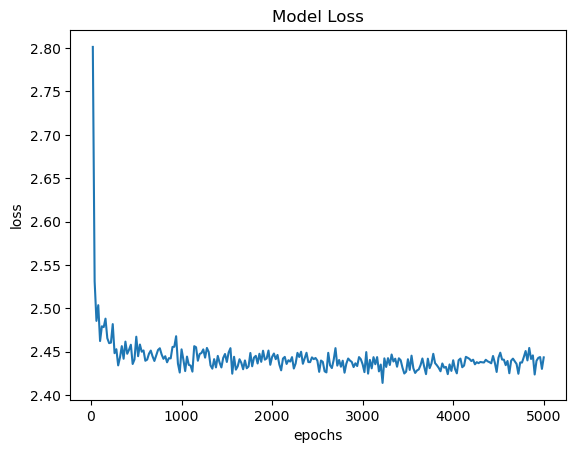

In [17]:
sns.lineplot(y=rnn_losses[1][1:],x=rnn_losses[0][1:])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epochs")

In [18]:
x="watson what are you"
x=torch.tensor([stoi[c] for c in x], device=device)[None, ...]
y=generate(rnn_model,x,100, top_k=3)
print("".join([itos[i] for i in y[0].tolist()]))

watson what are youthitherere athan the hanghin at ato at thind an thin at has tond hasther t the thithinderere hed the


In [19]:
x="i am writing this prompt"
x=torch.tensor([stoi[c] for c in x], device=device)[None, ...]
y=generate(rnn_model,x,100, top_k=3)
print("".join([itos[i] for i in y[0].tolist()]))

i am writing this prompthe t tond athe the t the thand he t the he the han t athas there athin to t athan herere at t t hed 


## Decoding Strategies

The ``generate_text`` utility we used above used every output prediction as input for the next time step. This method of using the highest probability prediction as output is called __Greedy Decoding__. Greeding decoding is fast and simple but is marred with issues we saw in samples we just generated.

Focusing on only highest probability output narrows our model's focus to just the next step which inturn may result in inconsistent or non-dictionary terms/words.

### Beam Search
Beam search is the obvious next step to improve the output predictions from the model. Instead of being greedy, beam search keeps track of n paths at any given time and selects the path with overall higher probability.

<img src="assets/beamsearch_nb_2.png">

### Other Key Decoding Strategies:
- Sampling
- Top-k Sampling
- Nucleus Sampling

### Temperature
Though sampling helps bring in required amount of randomness, it is not free from issues. Random sampling leads to gibberish and incoherence at times. To control the amount of randomness, we introduce __temperature__. This parameter helps increase the likelihood of high probability terms reduce the likelihood of low probability ones. This leads to sharper distributions. 

> High temperature leads to more randomness while lower temperature brings in predictability.


### The RNN Limitation
The RNN layer (LSTM, or GRU, etc.) takes in a context window of a defined size as input and encodes all of it into a single vector. This bottleneck vector needs to capture a lot of information in itself before the decoding stage can use it to start generating the next token.

## Attention is All You Need

<img src="assets/transformer_notebook_1.jpg">


### Attention to the Rescue
Attention is one of the most powerful concepts in the deep learning space that really changed the game. The core idea behind the attention mechanism is to make use of all interim hidden states of the RNN to decide which one to focus upon before it is used by the decoding stage. 

### Contextual Embeddings
The [TagLM architecture by Peters et al. in 2017](https://arxiv.org/abs/1705.00108) was one of the first works that provided an insight into how we could combine __pre-trained word embeddings__ with a __pre-trained neural language model__ to generate __context-aware embeddings__ for downstream NLP tasks.

The big breakthrough that changed the NLP landscape came in the form of __ELMo, or Embeddings from Language Models__. The ELMo architecture was presented by Peters et al. in their work titled [__Deep Contextualized Word Representations in 2018__](https://arxiv.org/abs/1802.05365). Without going into too much detail, the main highlights of the ELMo architecture were:

- The model used a bi-LSTM-based language model.
- Character CNNs were used to generate embeddings, in place of pre-trained word vectors, which made use of huge 4096 LSTM units but transformed into smaller 512-sized vectors using feedforward layers.
- The main innovation was to make use of all the hidden bi-LSTM layers for generating input representation. Unlike previous works, where only the final LSTM layer was used to fetch the representation of the input, this work took a weighted average of all the hidden layers' hidden states. This helped the model learn contextual word embeddings where each layer contributed to things like syntax and semantics.

## Self-Attention
- Self-attention was proposed by Cheng et al. in their paper titled Long Short-Term Memory Networks for Machine Reading in 2016
- Self-attention enables a model to learn the correlation between the current token (character or word or sentence, etc.) and its context window. In other words, it is an attention mechanism that relates different positions of a given sequence so as to generate a representation of the same sequence

## Transformers
- The transformer architecture was presented in the seminal paper __Attention is All You Need__ by Vaswani et al. back in 2017
- A transformer is a __recurrence-__ and __convolution-free__ attention-based encoder-decoder architecture
- Introduced the concept of multi-head attention and positional encodings
- Also revolutionalised Computer Vision domain (see ViT)


<img src="assets/transformer_arch_notebook_1.png">


## BERT-ology
- BERT, or __[Bi-Directional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)__, was presented by Devlin et al., a team at Google AI in 2018
- Multi-task Learning: BERT also helped push the transfer-learning envelope in the NLP domain by showcasing how a pre-trained model can be fine-tuned for various tasks to provide state-of-the-art performance
- BERT tweaked the usual Language Model objective to only predict next token based on past context by building context from both directions, i.e. the objective of predicting masked words along with next sentence prediction.


<img src="assets/bert_models_layout_notebook_1.jpeg">

> source [PLM Papers](https://github.com/thunlp/PLMpapers)

